In [1]:
#Imports
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
import matplotlib.pyplot as plt

### Benchmarking: Dense, LSTM, Moving Average
This notebook setups the benchmarking for our Flexibility Baselien Forecaster with synthetic control. This includes
- Data Preperation
- Dense and LSTM Forecaster
- Result storing and visualization

In [2]:
class ForecastingPipeline:
    def __init__(self, model_type='dense', lookback_steps=48, horizon=1, iterations=1):  # 48 steps = 1 day (with 30min intervals)
        self.model_type = model_type.lower()  # 'dense' or 'lstm'
        self.lookback_steps = lookback_steps
        self.horizon = horizon
        self.iterations = iterations
        self.scaler = MinMaxScaler()
        self.model = None
        self.history = None
        self.metrics_history = []  # Store metrics for each iteration
        self.iteration_histories = []  # Store training history for each iteration
        self.y_true_list = []  # Store true values for each iteration
        self.y_pred_list = []  # Store predictions for each iteration
        self.y_train_true_list = []  # Store training true values
        self.y_train_pred_list = []  # Store training predictions
        self.y_val_true_list = []    # Store validation true values
        self.y_val_pred_list = []    # Store validation predictions
        self.current_building_id = None  # Store current building ID
        
    def prepare_sequences(self, data):
        """Create sequences for time series forecasting"""
        X, y = [], [] # Initialize empty lists for input sequences and target values
        for i in range(len(data) - self.lookback_steps): # Iterate through the data, leaving room for lookback
            X.append(data[i:(i + self.lookback_steps)]) # Add a sequence of lookback_steps to X
            y.append(data[i + self.lookback_steps]) # Add the next value after the sequence to y
        return np.array(X), np.array(y) # Convert lists to numpy arrays and return
    
    def prepare_data(self, df, building_id):
        """Prepare data for training"""
        
        # Extract netconsumption column of the building and scale it
        consumption = df[f'netconsumption_{building_id}'].values.reshape(-1, 1) #Reshape of compatibility - a -> [a]
        self.scaler.fit(consumption)  # Fit scaler on all data
        scaled_data = self.scaler.transform(consumption) # Transform consumption data using fitted scaler
        
        # Create sequences
        X, y = self.prepare_sequences(scaled_data)
        
        # Split data into train and test sets, using 20% for test, maintaining time order
        X_train, X_test, y_train, y_test = train_test_split( 
            X, y, test_size=0.3, shuffle=False 
        )
        
        return X_train, X_test, y_train, y_test
    
    def build_dense_model(self):
        """Build and compile the neural network"""
        model = Sequential([
            Input(shape=(self.lookback_steps, 1)), # 1 Feature as input
            Dense(64, activation='relu'), 
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Flatten(),  # Flatten the output before final prediction
            Dense(self.horizon)
        ])
        
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        
        self.model = model
        return model
    
    def build_lstm_model(self):
        """Build and compile the LSTM model"""
        model = Sequential([
            Input(shape=(self.lookback_steps, 1)),
            LSTM(8, return_sequences=True),
            Dropout(0.2),
            LSTM(8),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(self.horizon)
        ])
        
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def build_model(self):
        """Build and compile the selected neural network"""
        if self.model_type == 'dense':
            self.model = self.build_dense_model()
        elif self.model_type == 'lstm':
            self.model = self.build_lstm_model()
        else:
            raise ValueError(f"Unknown model type: {self.model_type}. Choose 'dense' or 'lstm'.")
        
        return self.model
    
    def train(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0):
        """Train the model"""
        
        # Split training data into train and validation sets
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_final = X_train[:train_size]
        y_train_final = y_train[:train_size]
        X_val = X_train[train_size:]
        y_val = y_train[train_size:]

        # Define early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            mode='min'
        )

        self.history = self.model.fit(
            X_train_final, y_train_final,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=verbose,
            callbacks=[early_stopping]
        )

        # Store training and validation predictions
        train_pred = self.predict(X_train_final)
        val_pred = self.predict(X_val)
        
        # Store true values and predictions
        self.y_train_true_list.append(self.scaler.inverse_transform(y_train_final.reshape(-1, 1)))
        self.y_train_pred_list.append(train_pred)
        self.y_val_true_list.append(self.scaler.inverse_transform(y_val.reshape(-1, 1)))
        self.y_val_pred_list.append(val_pred)

    def predict(self, X, verbose=0):
        """Make predictions"""
        predictions = self.model.predict(X, verbose=verbose)
        # predictions are already 2D (samples, 1) due to Flatten layer
        return self.scaler.inverse_transform(predictions)

    def calculate_metrics(self, y_true, y_pred):
        """Calculate MAE, MSE, and RMSE"""
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return {'mae': mae, 'mse': mse, 'rmse': rmse}

    def clear_storage(self):
        """Clear all storage for new run"""
        self.metrics_history = []
        self.iteration_histories = []
        self.y_true_list = []
        self.y_pred_list = []
        self.y_train_true_list = []
        self.y_train_pred_list = []
        self.y_val_true_list = []
        self.y_val_pred_list = []

    def run_iterations(self, df, building_id, epochs=50, batch_size=32, validation_split=0.2, verbose=0, visualize=False):
        """Run multiple iterations of training and evaluation"""
        self.current_building_id = building_id  # Store building ID
        # Clear all storage lists for new building
        self.clear_storage()

        for i in range(self.iterations):
            print(f"\nBuilding {self.current_building_id} - Iteration {i+1}/{self.iterations} - {self.model_type}")
            
            # Prepare data
            X_train, X_test, y_train, y_test = self.prepare_data(df, building_id)
            
            # Build and train model
            self.build_model()
            self.train(X_train, y_train, epochs, batch_size, validation_split, verbose)
            
            # Make predictions
            y_pred = self.predict(X_test, verbose=verbose)
            y_test_orig = self.scaler.inverse_transform(y_test.reshape(-1, 1))
        
            # Store history and predictions
            self.iteration_histories.append(self.history)
            self.y_true_list.append(y_test_orig)
            self.y_pred_list.append(y_pred)
            
            # Calculate metrics
            metrics = self.calculate_metrics(y_test_orig, y_pred)
            self.metrics_history.append(metrics)
            
            # Plot training history and predictions for this iteration
            if visualize:
                # Plot results for this iteration
                print(f"\nIteration {i+1} metrics:")
                print(f"MAE: {metrics['mae']:.2f}")
                print(f"MSE: {metrics['mse']:.2f}")
                print(f"RMSE: {metrics['rmse']:.2f}")

                self.plot_history(i)
                self.plot_predictions(y_test, y_pred, num_samples=100, iteration=i)
        
        if visualize:
            self.summarize_metrics()
    
    def get_results_dataframes(self):
        """Return three dataframes containing all results"""
        # 1. DataFrame with true and predicted values
        predictions_data = {}

        # Calculate true values only once, outside the loop
        true_values = np.concatenate([
            self.y_train_true_list[0].flatten(),
            self.y_val_true_list[0].flatten(),
            self.y_true_list[0].flatten()
        ])
        predictions_data['value'] = true_values

        # Now loop only for predictions
        for iteration in range(self.iterations):
            pred_values = np.concatenate([
                self.y_train_pred_list[iteration].flatten(),
                self.y_val_pred_list[iteration].flatten(),
                self.y_pred_list[iteration].flatten()
            ])

            # Add predictions with formatted column name
            col_name = f'pred_{self.model_type}_iter{iteration+1}_bld{self.current_building_id}'
            predictions_data[col_name] = pred_values

        predictions_df = pd.DataFrame(predictions_data)

        # Add index information
        n_train, n_val, n_test = len(self.y_train_true_list[0]), len(self.y_val_true_list[0]), len(self.y_true_list[0])
        predictions_df.index = ['train'] * n_train + ['val'] * n_val + ['test'] * n_test
        
        # 2. DataFrame with metrics for each iteration
        metrics_data = []
        for i, metrics in enumerate(self.metrics_history):
            metrics_dict = {
                'building_id': self.current_building_id,
                'model_type': self.model_type,
                'iteration': i + 1
            }
            metrics_dict.update(metrics)
            metrics_data.append(metrics_dict)
        
        iterations_metrics_df = pd.DataFrame(metrics_data)
        
        # 3. Summary DataFrame with renamed columns
        metrics_df = pd.DataFrame(self.metrics_history)
        
        # Create empty lists to store the data
        data = []

        for metric in ['mae', 'mse', 'rmse']:
            for stat in ['mean', 'min', 'max', 'std']:
                # Calculate the statistic value
                if stat == 'mean':
                    value = metrics_df[metric].mean()
                elif stat == 'min':
                    value = metrics_df[metric].min()
                elif stat == 'max':
                    value = metrics_df[metric].max()
                else:  # std
                    value = metrics_df[metric].std()
                    
                # Create a row with separate columns
                row = {
                    'building_id': self.current_building_id,
                    'model_type': self.model_type,
                    'metric': metric,
                    'statistic': stat,
                    'value': value
                }
                data.append(row)

        # Create the DataFrame with the new structure
        summary_df = pd.DataFrame(data)
        
        return predictions_df, iterations_metrics_df, summary_df

    def summarize_metrics(self):
        """Summarize metrics across all iterations"""
        metrics_df = pd.DataFrame(self.metrics_history)
        
        summary = {
            'metric': ['MAE', 'MSE', 'RMSE'],
            'mean': [
                metrics_df['mae'].mean(),
                metrics_df['mse'].mean(),
                metrics_df['rmse'].mean()
            ],
            'std': [
                metrics_df['mae'].std(),
                metrics_df['mse'].std(),
                metrics_df['rmse'].std()
            ],
            'min': [
                metrics_df['mae'].min(),
                metrics_df['mse'].min(),
                metrics_df['rmse'].min()
            ],
            'max': [
                metrics_df['mae'].max(),
                metrics_df['mse'].max(),
                metrics_df['rmse'].max()
            ]
        }
        
        summary_df = pd.DataFrame(summary)
        print("\nMetrics Summary Across All Iterations:")
        print(summary_df.to_string(index=False))
        
        return summary_df
            
    def plot_history(self, iteration=None):
        """Plot training history for a specific iteration"""
        history = self.iteration_histories[iteration] if iteration is not None else self.history
        
        plt.figure(figsize=(14, 3))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        title = 'Model Loss'
        if iteration is not None:
            title += f' (Iteration {iteration+1})'
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        title = 'Model MAE'
        if iteration is not None:
            title += f' (Iteration {iteration+1})'
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_predictions(self, y_true, y_pred, num_samples=100, iteration=None):
        """Plot actual vs predicted values"""
        plt.figure(figsize=(14, 3))
        
        # Convert scaled values back to original scale if needed
        if len(y_true.shape) == 1:
            y_true = y_true.reshape(-1, 1)
        y_true_orig = self.scaler.inverse_transform(y_true)[:num_samples]
        
        plt.plot(y_true_orig, label='Actual', alpha=0.7)
        plt.plot(y_pred[:num_samples], label='Predicted', alpha=0.7)
        
        title = 'Actual vs Predicted Net Consumption'
        if iteration is not None:
            title += f' (Iteration {iteration+1})'
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Net Consumption')
        plt.legend()
        plt.grid(True)
        plt.show()

In [3]:
def append_results(all_predictions, predictions_dense_df, all_iterations_metrics, iterations_metrics_dense_df, summary_dense_df, all_summaries):
    all_predictions.append(predictions_dense_df)
    #all_predictions.append(predictions_lstm_df)
    all_iterations_metrics.append(iterations_metrics_dense_df)
    #all_iterations_metrics.append(iterations_metrics_lstm_df)
    all_summaries.append(summary_dense_df)
    #all_summaries.append(summary_lstm_df)

    return all_predictions, all_iterations_metrics, all_summaries

def concate_and_save_all_results(path, all_predictions, all_iterations_metrics, all_summaries):
    # Concatenate results from all buildings
    final_predictions_df = pd.concat(all_predictions, axis=1)
    final_predictions_df = final_predictions_df.loc[:,~final_predictions_df.columns.duplicated()] # Drop duplicate value columns
    final_iterations_metrics_df = pd.concat(all_iterations_metrics, axis=0, ignore_index=True)
    final_summary_df = pd.concat(all_summaries, axis=0, ignore_index=True)

    # Ensure the directory exists
    if not os.path.exists(path):
        os.makedirs(path)

    final_predictions_df.to_csv(path+"final_predictions_df.csv")
    final_iterations_metrics_df.to_csv(path+"final_iterations_metrics_df.csv")
    final_summary_df.to_csv(path+"final_summary_df.csv")

    return final_predictions_df, final_iterations_metrics_df, final_summary_df


Building 1 - Iteration 1/3 - dense

Iteration 1 metrics:
MAE: 2.83
MSE: 11.00
RMSE: 3.32


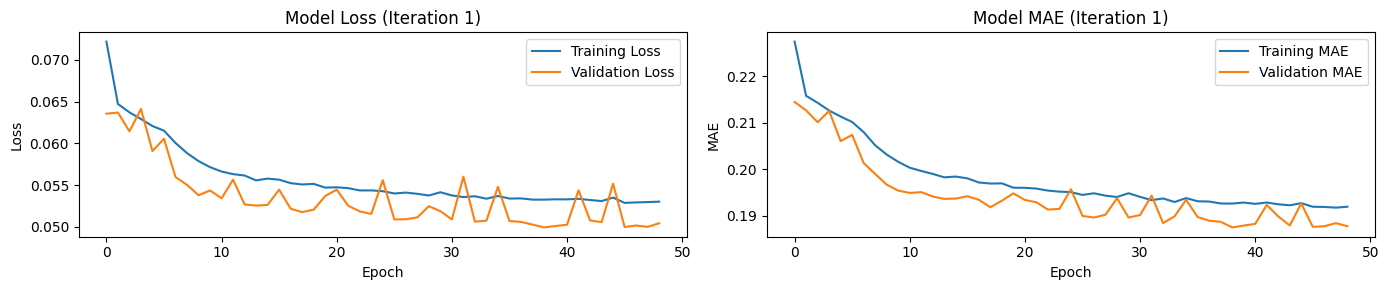

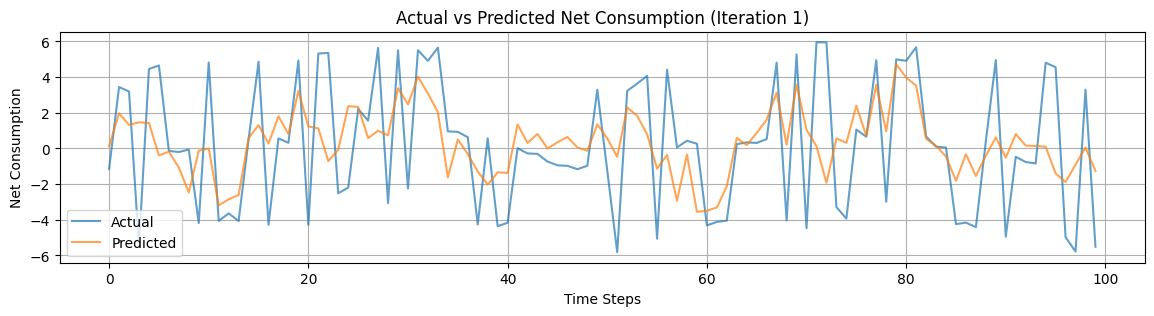


Building 1 - Iteration 2/3 - dense


KeyboardInterrupt: 

In [6]:
# BUILDINGS 1-100

ITERATIONS = 3
HORIZON = 1
LOOCKBACK = 48
BATCH_SIZE = 32
EPOCHS=100
BUILDINGS = 100 #MAX 300

df = pd.read_csv("../../data/Energy_dataset.csv", header=0, index_col=0)

# Prepare Pipelines for networks
pipeline_dense = ForecastingPipeline(model_type='dense', lookback_steps=LOOCKBACK, horizon=HORIZON, iterations=ITERATIONS)
#pipeline_lstm = ForecastingPipeline(model_type='lstm', lookback_steps=LOOCKBACK, horizon=HORIZON, iterations=ITERATIONS)

# Initialize empty lists to store results for each building
all_predictions = []
all_iterations_metrics = []
all_summaries = []

for building_id in range(1,BUILDINGS+1):
    
    # Run all iterations
    pipeline_dense.run_iterations(
        df, building_id=building_id, epochs=EPOCHS, batch_size=BATCH_SIZE, 
        validation_split=0.2, verbose=0, visualize=True)
    #pipeline_lstm.run_iterations(df, building_id=building_id, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0, visualize=False)
    
    # Get the results dataframes
    predictions_dense_df, iterations_metrics_dense_df, summary_dense_df = pipeline_dense.get_results_dataframes()
    #predictions_lstm_df, iterations_metrics_lstm_df, summary_lstm_df = pipeline_lstm.get_results_dataframes()

    # Append results to our lists
    all_predictions, all_iterations_metrics, all_summaries = append_results(
        all_predictions, predictions_dense_df, all_iterations_metrics, 
        iterations_metrics_dense_df, summary_dense_df, all_summaries
        )
    
final_predictions_df, final_iterations_metrics_df, final_summary_df = concate_and_save_all_results("../../data/benchmarks/dense/1_100/", all_predictions, all_iterations_metrics, all_summaries)

In [5]:
# BUILDINGS 100-200

ITERATIONS = 3
HORIZON = 1
LOOCKBACK = 48
BATCH_SIZE = 32
EPOCHS=100 

df = pd.read_csv("../../data/Energy_dataset.csv", header=0, index_col=0)

# Prepare Pipelines for networks
pipeline_dense = ForecastingPipeline(model_type='dense', lookback_steps=LOOCKBACK, horizon=HORIZON, iterations=ITERATIONS)
#pipeline_lstm = ForecastingPipeline(model_type='lstm', lookback_steps=LOOCKBACK, horizon=HORIZON, iterations=ITERATIONS)

# Initialize empty lists to store results for each building
all_predictions = []
all_iterations_metrics = []
all_summaries = []

for building_id in range(101,201):
    
    # Run all iterations
    pipeline_dense.run_iterations(df, building_id=building_id, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0, visualize=False)
    #pipeline_lstm.run_iterations(df, building_id=building_id, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0, visualize=False)
    
    # Get the results dataframes
    predictions_dense_df, iterations_metrics_dense_df, summary_dense_df = pipeline_dense.get_results_dataframes()
    #predictions_lstm_df, iterations_metrics_lstm_df, summary_lstm_df = pipeline_lstm.get_results_dataframes()

    # Append results to our lists
    all_predictions, all_iterations_metrics, all_summaries = append_results(
        all_predictions, predictions_dense_df, all_iterations_metrics, 
        iterations_metrics_dense_df, summary_dense_df, all_summaries
        )
    
final_predictions_df, final_iterations_metrics_df, final_summary_df = concate_and_save_all_results("../../data/benchmarks/dense/101_200/", all_predictions, all_iterations_metrics, all_summaries)


Building 101 - Iteration 1/3 - dense

Building 101 - Iteration 2/3 - dense

Building 101 - Iteration 3/3 - dense

Building 102 - Iteration 1/3 - dense

Building 102 - Iteration 2/3 - dense

Building 102 - Iteration 3/3 - dense

Building 103 - Iteration 1/3 - dense

Building 103 - Iteration 2/3 - dense

Building 103 - Iteration 3/3 - dense

Building 104 - Iteration 1/3 - dense

Building 104 - Iteration 2/3 - dense

Building 104 - Iteration 3/3 - dense

Building 105 - Iteration 1/3 - dense

Building 105 - Iteration 2/3 - dense

Building 105 - Iteration 3/3 - dense

Building 106 - Iteration 1/3 - dense

Building 106 - Iteration 2/3 - dense

Building 106 - Iteration 3/3 - dense

Building 107 - Iteration 1/3 - dense

Building 107 - Iteration 2/3 - dense

Building 107 - Iteration 3/3 - dense

Building 108 - Iteration 1/3 - dense

Building 108 - Iteration 2/3 - dense

Building 108 - Iteration 3/3 - dense

Building 109 - Iteration 1/3 - dense

Building 109 - Iteration 2/3 - dense

Building 10

KeyboardInterrupt: 

In [ ]:
# BUILDINGS 201-300

ITERATIONS = 3
HORIZON = 1
LOOCKBACK = 48
BATCH_SIZE = 32
EPOCHS=100 

df = pd.read_csv("../../data/Energy_dataset.csv", header=0, index_col=0)

# Prepare Pipelines for networks
pipeline_dense = ForecastingPipeline(model_type='dense', lookback_steps=LOOCKBACK, horizon=HORIZON, iterations=ITERATIONS)
#pipeline_lstm = ForecastingPipeline(model_type='lstm', lookback_steps=LOOCKBACK, horizon=HORIZON, iterations=ITERATIONS)

# Initialize empty lists to store results for each building
all_predictions = []
all_iterations_metrics = []
all_summaries = []

for building_id in range(201,301):
    
    # Run all iterations
    pipeline_dense.run_iterations(df, building_id=building_id, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0, visualize=False)
    #pipeline_lstm.run_iterations(df, building_id=building_id, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0, visualize=False)
    
    # Get the results dataframes
    predictions_dense_df, iterations_metrics_dense_df, summary_dense_df = pipeline_dense.get_results_dataframes()
    #predictions_lstm_df, iterations_metrics_lstm_df, summary_lstm_df = pipeline_lstm.get_results_dataframes()

    # Append results to our lists
    all_predictions, all_iterations_metrics, all_summaries = append_results(
        all_predictions, predictions_dense_df, all_iterations_metrics, 
        iterations_metrics_dense_df, summary_dense_df, all_summaries
        )
    
final_predictions_df, final_iterations_metrics_df, final_summary_df = concate_and_save_all_results("../../data/benchmarks/dense/201_300/", all_predictions, all_iterations_metrics, all_summaries)